In [5]:
import pandas
import numpy
import matplotlib.pyplot as plt
from collections import namedtuple
from tqdm import tqdm

In [6]:
class ElectionSampler:
    cases = None
    threshold = None
    
    def decide_case(self, groups: pandas.Series):
        number_over_threshold = (groups > self.threshold).sum()
        return self.cases[number_over_threshold]

    def sample(self, groups: pandas.Series):
        """
        :param pandas.Series groups: a single row of a DataFrame with the percentages
            of each racial group in a ward.
        """
        outcomes, probabilities = self.decide_case(groups)
        outcome = numpy.random.choice(a=outcomes, p=probabilities)
        groups_from_highest_to_lowest = groups.sort_values(ascending=False).keys()
        result = zip(groups_from_highest_to_lowest, outcome)
        return result

class ElectionSamplerWithMajority(ElectionSampler):
    def decide_case(self, groups: pandas.Series):
        number_over_threshold = (groups > self.threshold).sum()
        any_majority = (groups > 0.5).any()
        if any_majority and number_over_threshold in self.cases["majority"]:
            return self.cases["majority"][number_over_threshold]
        else:
            return self.cases["majority"][number_over_threshold]


In [7]:
Case = namedtuple("Case", ["outcomes", "probabilities"])

In [8]:
class TenByFiveSampler(ElectionSampler):
    cases = {
        1: Case(outcomes=((5,), (4,1)), probabilities=(0.5, 0.5)),
        2: Case(((4, 1), (3, 2), (2, 3), (2, 2, 1), (3, 1, 1)), (0.25, 0.55, 0.1, 0.05, 0.05)),
        3: Case(((3, 1, 1), (3, 2), (2, 3), (2, 2, 1), (2, 1, 2)), (0.25, 0.25, 0.15, 0.2, 0.15)),
        4: Case(((3, 1, 1), (3, 2), (2, 3), (2, 2, 1), (2, 1, 2)), (0.2, 0.2, 0.2, 0.2, 0.2))
    }
    threshold = 1/6

class FiftyByOneSampler(ElectionSamplerWithMajority):
    """
    Tweaks:
    if 2 groups over 25%:
        if one over 50%: 90-10
        else: 60-40
    if 3:
        if one over 50%: 80-18-2
        else: 45-30-25
    """
    cases = {
        "majority": {
            2: Case(((1, 0), (0,1)), (0.9, 0.1)),
            3: Case(((1,0,0), (0,1,0), (0,0,1)), (0.8, 0.18, 0.02))
        },
        "plurality": {
            1: Case(outcomes=((1,),), probabilities=(1,)),
            2: Case(((1, 0), (0,1)), (0.6, 0.4)),
            3: Case(((1,0,0), (0,1,0), (0,0,1)),(0.45, 0.3, 0.25))
        }
    }
    threshold = 0.25
    
class TenByThreeSampler(ElectionSamplerWithMajority):
    cases = {
        "majority": {
            1: Case(outcomes=((3,), (2,1)), probabilities=(0.9, 1)),
            2: Case(((3,), (2,1)), (0.2, 0.8)),
            3: Case(((3,), (2,1), (1,2), (1,1,1)), (0.1, 0.5, 0.3, 0.1)),
            
        },
        "plurality": {
            1: Case(((3,), (2,1)), (0.5, 0.5)),
            2: Case(((3,), (2,1), (1,2), (1,1,1)), (0.1, 0.1, 0.8)),
            3: Case(((3,), (2,1), (1,2), (1,1,1)), (0.05, 0.15, 0.1, 0.7))
        }
    }
    threshold = 0.25

In [5]:
def load_data(filename):
    df = pandas.read_csv(filename)
    data = pandas.DataFrame(
        {
            "step": df["step"],
            "ward": df["ward"],
            "White": df["NH_WHITE"] / df["TOTPOP"],
            "Black": df["NH_BLACK"] / df["TOTPOP"],
            "Hispanic": df["HISP"] / df["TOTPOP"],
            "Asian": df["NH_ASIAN"] / df["TOTPOP"],
        }
    )
    return data

In [9]:
def random_sample(data, size, sampler):
    groups = ["White", "Black", "Hispanic", "Asian"]
    
    plans = data["step"].unique()
    plan_indices = numpy.random.choice(plans, size=size)
    for plan_index in tqdm(plan_indices):
        wards = data[data["step"] == plan_index]
        results = {group: 0 for group in groups}
        for index, ward in wards.iterrows():
            for group, wins in sampler.sample(ward[groups]):
                results[group] += wins
        yield results

In [10]:
data = load_data("./mggg_chicago/ca10/results_10x5_CAs.csv")

In [11]:
outcomes = pandas.DataFrame.from_records(random_sample(data, 100000, TenByFiveSampler()))

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [33:24<00:00, 49.88it/s]


In [12]:
groups = ["White", "Black", "Hispanic", "Asian"]

In [13]:
outcomes.to_csv("./projection_10x5_CA.csv")

In [23]:
outcomes.groupby(groups).size().to_csv("./projection_10x5_CA_counts.csv", header=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019933EAFB00>,
      dtype=object)

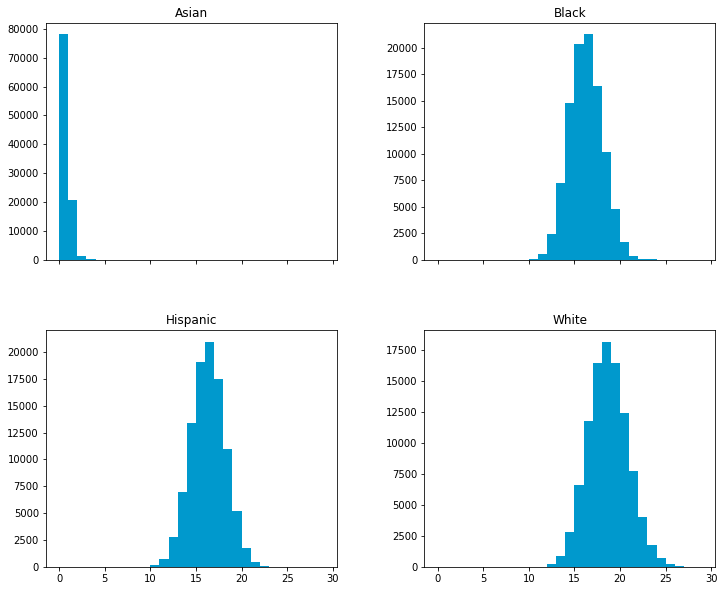

In [22]:
outcomes[groups].hist(sharex=True, grid=False, figsize=(12,10), color="#0099cd", bins=list(range(30)))